In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def name_map():
    return {
        "m_jj": "$m_{{\\rm jj}}$",
        "met": "MET",
        "ht": "HT",
        "pT_j1": "Leading jet $p_{{\\rm T}}$",
        "pT_j2": "Sub-leading jet $p_{{\\rm T}}$",
        "tau21_j1": "Leading jet $\\tau_2/\\tau_1$",
        "tau21_j2": "Sub-leading jet $\\tau_2/\\tau_1$",
        "tau32_j1": "Leading jet $\\tau_3/\\tau_2$",
        "tau32_j2": "Sub-leading jet $\\tau_3/\\tau_2$",
        "min_dPhi": "min$\\Delta\\phi(\\rm j_i, \\rm MET)$",
    }

def unit_map():
    return {
        "m_jj": "(GeV)",
        "met": "(GeV)",
        "ht": "(GeV)",
        "pT_j1": "(GeV)",
        "pT_j2": "(GeV)",
        "tau21_j1": "",
        "tau21_j2": "",
        "tau32_j1": "",
        "tau32_j2": "",
        "min_dPhi": "",
    }


def pretty_name_map():
    return {
        "m_jj": "$m_{jj}$",
        "met": "MET",
        "ht": "$H_T$",
        "pT_j1": "(GeV)",
        "pT_j2": "(GeV)",
        "tau21_j1": "$\tau_{21}_^{j1}$",
        "tau21_j2": "$\tau_{21}_^{j2}$",
        "tau32_j1": "$\tau_{32}_^{j1}$",
        "tau32_j2": "$\tau_{32}_^{j2}$",
        "min_dPhi": "",
    }

def load_samples(file):
    samples = np.loadtxt(file, dtype=str)
    # Get the names of all varibles
    variables = samples[0]
    # Get the events ordered by varibles
    events = np.asfarray(samples[1:])
    return variables, events


def sort_event_arr(names, variables, events):
    
    event_list = []
    
    for x in names:   
        ind_x = ind(variables, x)
        event_list.append(events[:, ind_x])
    
    return np.stack(event_list, axis=1)


def get_quality_events(arr):

    if np.isnan(arr).any():
        return arr[~np.isnan(arr).any(axis=1)]
    
    else:
        return arr
    
def ind(variables, name):
    return np.where(variables == name)[0][0]

In [3]:
sig_sample = "/global/cfs/cdirs/m3246/kbai/HV_samples/sig_samples/rinv13_pTmin200GeV.txt"
bkg_dir = "/global/cfs/cdirs/m3246/kbai/HV_samples/qcd_data_samples/" 

In [4]:
# define sample size as the number of files
sample_size = 10
print(f"loadging {sample_size} samples...")

# load signal first
var_names = ["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
variables, sig = load_samples(sig_sample)
sig = get_quality_events(sig)
sig_events = sort_event_arr(var_names, variables, sig)

loadging 10 samples...


In [5]:
bkg_events_list = []
ideal_bkg_events_list = []
mc_events_list = []

for i in range(sample_size):

    bkg_path = f"{bkg_dir}/qcd_{i}.txt"

    if os.path.isfile(bkg_path):

        # Load input events ordered by varibles
        _, bkg_i = load_samples(bkg_path)
        bkg_i = get_quality_events(bkg_i)
        bkg_events_list.append(sort_event_arr(var_names, variables, bkg_i))

if len(bkg_events_list)==0:
    print("No files loaded.")

In [6]:
bkg_events = np.concatenate(bkg_events_list)

In [45]:
def plot_all_variables(sig_list, bkg_list, xlabels, bins_list=[], labels=["sig", "bkg"], name="sig_vs_bkg", title="", xlabel="x", outdir="./", *args, **kwargs):
    csig = 'coral'
    cbkg = 'lightblue'

    N = len(sig_list)
    
    if N==len(xlabels):
        fig, ax1 = plt.subplots(1, N, figsize=(5*N,5))
        
        ax1[0].set_ylabel("a.u.", fontsize = 20)
        for i in range(N):
            #if len(bins_list)==0:
            #    xmax = np.max(np.hstack([bkg_list[i], sig_list[i]]))
            #    bins = np.linspace(0, xmax, 50)
            #else:
            bins = bins_list[i]
            ax1[i].hist(sig_list[i], bins = bins, density = True, histtype='step', ls= "-", color=csig, label=labels[0], lw=2)
            ax1[i].hist(bkg_list[i], bins = bins, density = True, histtype='stepfilled', ls= "-", color=cbkg, alpha=1, label=labels[1])
            ax1[i].set_xlabel(xlabels[i], fontsize = 20)
            ax1[i].set_yticks([])
            if i == 0:
                ax1[i].legend(fontsize = 16)
        plt.subplots_adjust(wspace=.0, hspace=0)
        plot_name = f"{outdir}/{name}.pdf"
        plt.savefig(plot_name.replace(" ", "_"))
        plt.show
        #plt.title(title)
        
        
        plt.close
    else:
        print("Wrong input lists!")

In [33]:
names = name_map()
units = unit_map()

bins_list = []
xlabel_list = []

n_bins = 40
for x in var_names:
    
    xlabel_list.append(f"{names[x]} {units[x]}")

    if "tau" in x:
        bins = np.linspace(0, 1, n_bins)
    elif x=="met":
        bins = np.linspace(0, 600, n_bins)
    elif x=="ht":
        bins = np.linspace(0, 4000, n_bins)
    elif x=="m_jj":
        bins = np.linspace(0, 4000, n_bins)
    
    bins_list.append(bins)

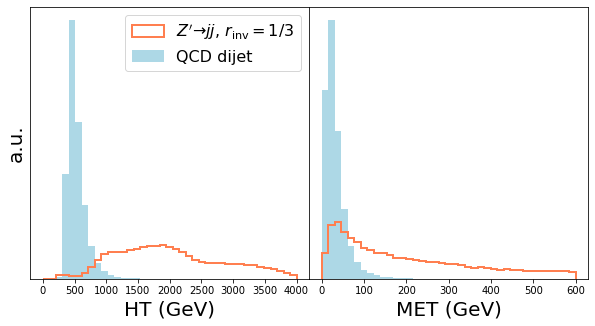

In [46]:
# Plot context varibles
sig_list = sig_events[:, :2].T
bkg_list = bkg_events[:, :2].T
xlabels = xlabel_list[:2]
bins = bins_list[:2]
labels=[r"$Z' \to jj$, $r_{\rm inv} = 1/3$", "QCD dijet"]

# Signal vs background
plot_kwargs = {"bins_list":bins, "name":f"sig_vs_bkg_cont", "labels":labels, "title":"Signal vs background in SR"}
plot_all_variables(sig_list, bkg_list, xlabels, **plot_kwargs)

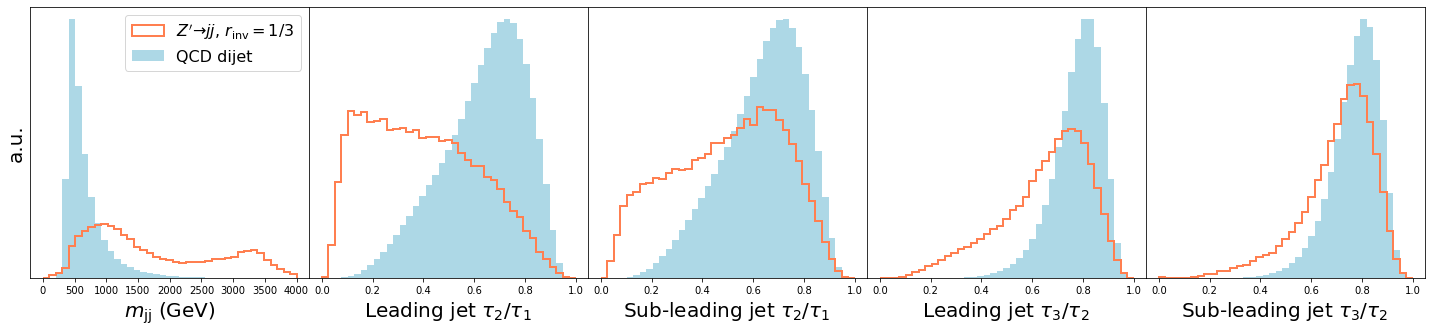

In [47]:
# Plot context varibles
sig_list = sig_events[:, 2:].T
bkg_list = bkg_events[:, 2:].T
xlabels = xlabel_list[2:]
bins = bins_list[2:]
labels=[r"$Z' \to jj$, $r_{\rm inv} = 1/3$", "QCD dijet"]

# Signal vs background
plot_kwargs = {"bins_list":bins, "name":f"sig_vs_bkg_feat", "labels":labels, "title":"Signal vs background in SR"}
plot_all_variables(sig_list, bkg_list, xlabels, **plot_kwargs)